# K channels: activation curve

#### **Basic instructions:**
#### 1. **To run code cells**, you can either hit the play button to the left of the cell, or you can select the cell and **press shift-enter**.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files over from where they are saved on your computer.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()

## 1. Choose the data file you want to analyze

#### Put the .abf files with your K channel recordings in the "data/K_channels" folder

In [5]:
data_folder = "data/2-K_channels"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/2-K_channels


['data/2-K_channels/K_IV.abf',
 'data/2-K_channels/K_deact_1.abf',
 'data/2-K_channels/K_deact_3.abf',
 'data/2-K_channels/K_deact_2.abf',
 'data/2-K_channels/2024_06_08_0007.abf',
 'data/2-K_channels/2024_06_08_0013.abf',
 'data/2-K_channels/2024_06_08_0014.abf']

Choose which file you want to analyze and past the file name here:

In [6]:
# data_file = 'data/2-K_channels/2024_06_08_0013.abf'
data_file = 'data/2-K_channels/K_IV.abf'

Now we can load the file and plot the raw data:

Trace('K_IV.abf')
Number of sweeps: 11
Points per sweep: 40,000
Duration per sweep: 0.800 s
Sampling rate: 50000 Hz
Sampling interval: 0.020 ms
Available channels: Current, Voltage, TTL


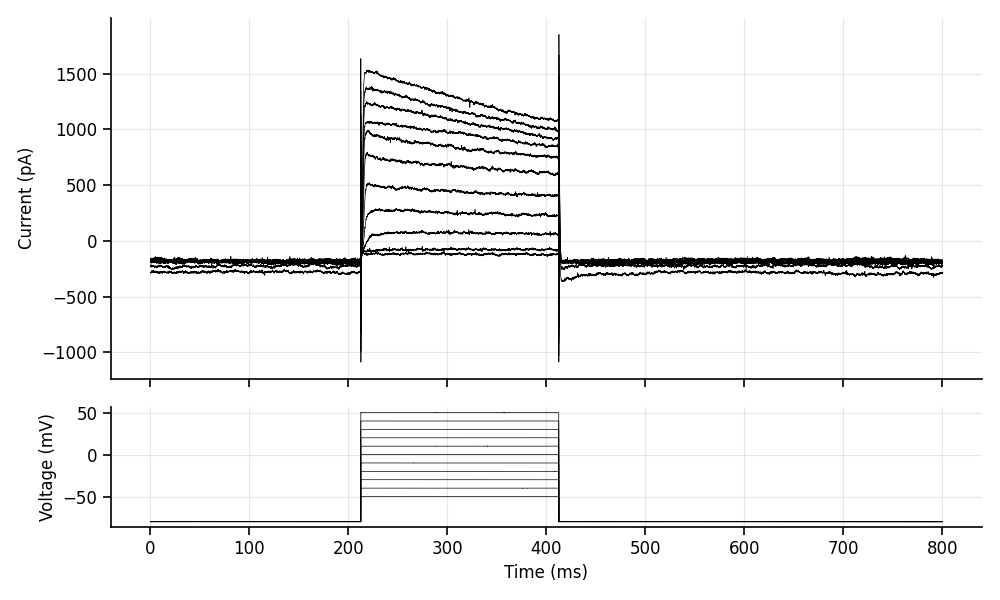

In [7]:
traces = Trace.from_axon_file(filename=data_file, 
                              load_voltage=True, 
                              load_ttl=True,
                              units=['pA', 'mV', 'V'], 
                              concatenate_sweeps=False)
print(traces)

time_units = 'ms' # specify seconds (s), or milliseconds (ms)

# ----------------------------------------------------------------------------------------------------------------
%matplotlib widget
traces.plot(plot_voltage=True, sweep='all', time_units=time_units)
plt.show()

## 2. Signal processing

### 2.1. Optional: apply baseline correction

If your baseline current is not zero, you may need to correct for that to get accurate measurements.

Uncomment this cell block (highlight everything, then cmd+/ on macOS or ctrl+/ on Windows) to run it.

In [8]:
# Change this to True if you want to subtract the baseline from the sweeps.
subtract_baseline = True

BASELINE SUBTRACTED:
Baseline currents: [-163.4521 -186.7981 -175.8423 ... -186.3708 -192.2607 -186.0046]


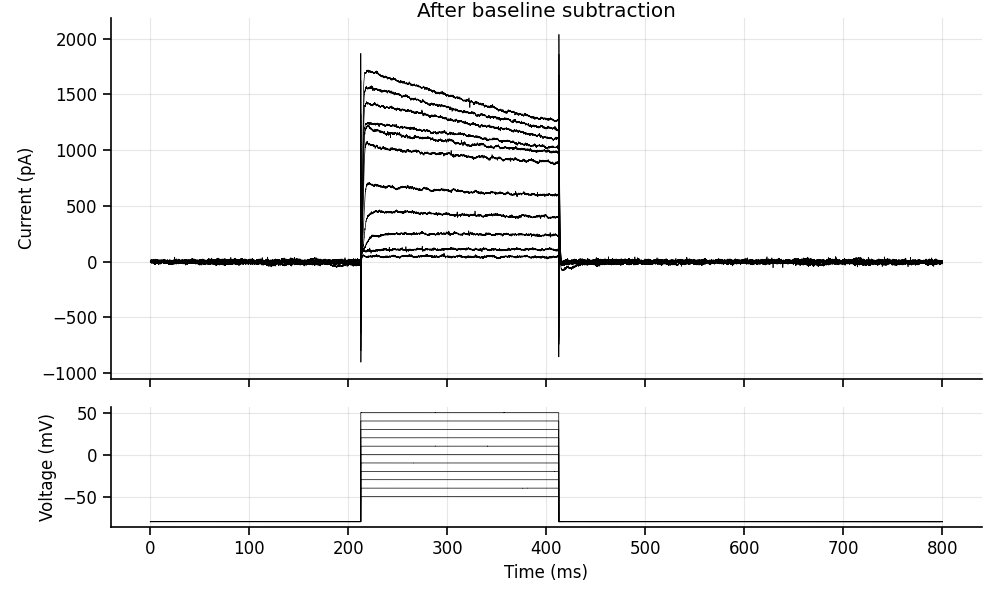

In [9]:
if subtract_baseline:
    traces.subtract_baseline(start_time = 0, 
                             end_time = 0.1, 
                             time_units = time_units,  # specify seconds (s), or milliseconds (ms)
                             channel = 'current')  # Options: 'current', 'voltage', 'all'
    %matplotlib widget
    ax1, ax2 = traces.plot(plot_voltage=True, plot_ttl=False, time_units=time_units, sweep='all')
    ax1.set_title('After baseline subtraction', y=0.98)
    plt.show()
else:
    print("BASELINE NOT SUBTRACTED")


### 2.2. Optional: apply additional highpass/lowpass filtering

Depending in you recording, you may have 50/60 Hz line noise, high-frequency noise, or drift in your recordings.

The goal here is to only remove the noise with minimal distortion of the data, so be careful not to overdo it

In [10]:
# Change this to True if you want to subtract the baseline from the sweeps.
additional_filtering = False

In [11]:
if additional_filtering:
    filtered_traces = traces
    # Step 1: Detrend the data to remove linear or constant trends.
    filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1)

    # Step 2: Apply a highpass filter to remove low-frequency noise + lowpass to remove high-frequency noise
    filtered_traces = filtered_traces.filter(
        line_freq=60,    # Frequency (Hz) of electrical noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width=0.5,         # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        highpass=0.5,   # Removes low-frequency drift. Set a value in Hz (e.g. 1 for 1 Hz).
        lowpass=4900,    # Removes high-frequency noise. Set a value in Hz (e.g. 100 for 100 Hz).
        order=4)         # Controls sharpness of the filter. Higher = sharper cutoff.

    %matplotlib widget
    ax = filtered_traces.plot(plot_voltage=False, plot_ttl=False)
    ax.set_title('After filtering', y=0.98)
    plt.show()

Once you are happy with the filter setting, run the next cell to implement them:

In [12]:
if additional_filtering:
    traces=filtered_traces

## 2. Select what you want to measure

### 2.1. Defining the time window

First let's define the relevant time window where we want to measure the currents:

(If you want to save the images, you can do it by clicking on the save icon in the top-right of the image when you hover over it)

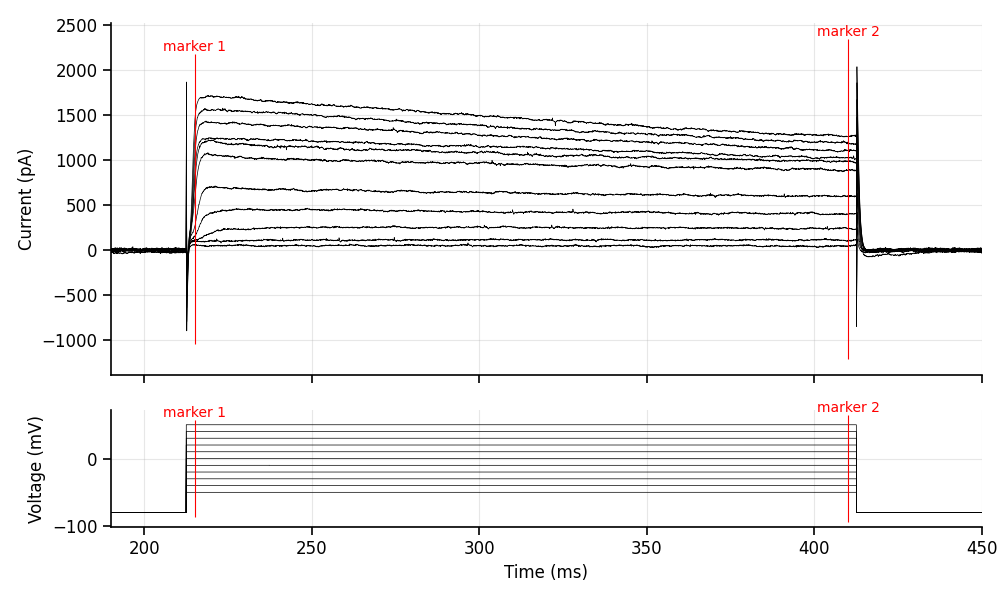

In [13]:
# The start/end time just helps to zoom in on the traces.
start_time = 190
end_time = 450

# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = 215
marker_2 = 410

# ----------------------------------------------------------------------------------------------------------------------
%matplotlib widget
ax1,ax2 = traces.plot(plot_voltage=True, time_units=time_units, marker_1=marker_1, marker_2=marker_2, sweep='all')
ax1.set_xlim(start_time,end_time)
ax2.set_xlim(start_time,end_time)
plt.show()

### 3.2. Measure currents

Here we will be using the timepoints from the markers we defined above.

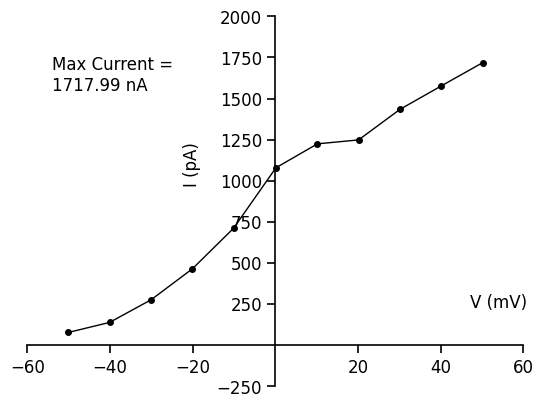

In [14]:
measurement_type = 'peak' # Options: 'mean', 'max', 'min', 'peak'

current_steps, voltage_steps = traces.get_measurements(start_time=marker_1, end_time=marker_2, 
                                                       measurement_type=measurement_type, time_units=time_units)

if np.all(voltage_steps == voltage_steps[0]):
    print("WARNING: All voltage steps are the same")
if np.all(current_steps == current_steps[0]):
    print("WARNING: All current steps are the same")
%matplotlib inline
ax = plot_IV(voltage_steps, current_steps, xlabel_coords=(0.95,0.25), ylabel_coords=(0.35,0.6))
I_max = np.max(current_steps)
ax.text(0.05, 0.8, f'Max Current = \n{I_max:.2f} nA', transform=ax.transAxes)
plt.show()

### 3.3. Get K activation curve and fit Boltzmann (sigmoid) 

We will be fitting this function (Boltzmann equation) to your data points:
$$ \frac{I}{I_{\text{max}}} = I_{norm} = \frac{1}{1 + \exp\left(\frac{V_{\text{half}} - V}{k}\right)}$$

V_half = -3.73 mV, k = 17.22


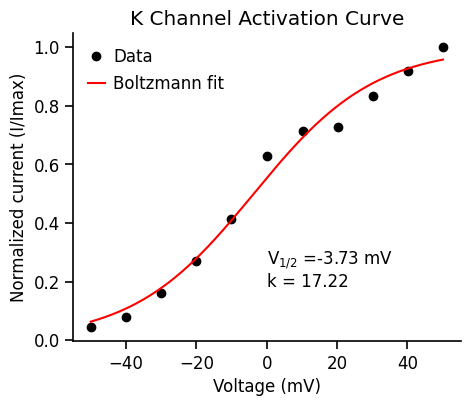

In [15]:
I_norm = current_steps / np.max(current_steps)

# Fit the Boltzmann function (sigmoidal curve) to the data and overlay
from scipy.optimize import curve_fit
def boltzmann(V, V_half, k):
    return 1 / (1 + np.exp((V_half - V) / k))
k_guess = 5 # Initial guess for the slope parameter to fit the curve
popt, _ = curve_fit(boltzmann, voltage_steps, I_norm, p0=[np.median(voltage_steps), k_guess])
V_half_fit, k_fit = popt
V_fit = np.linspace(np.min(voltage_steps), np.max(voltage_steps), 500)
I_fit = boltzmann(V_fit, V_half_fit, k_fit)
print(f"V_half = {V_half_fit:.2f} mV, k = {k_fit:.2f}")

# Plot normalized data points & fitted curve
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(voltage_steps, I_norm, 'o', label='Data', color='black')
ax.plot(V_fit, I_fit, '-', label='Boltzmann fit', color='red')
ax.text(0.5, 0.3, 'V$_{1/2}$ ='+f'{V_half_fit:.2f} mV \nk = {k_fit:.2f}', transform=ax.transAxes, ha='left', va='top')
ax.set_xlabel('Voltage (mV)')
ax.set_ylabel('Normalized current (I/Imax)')
ax.set_title('K Channel Activation Curve')
ax.legend(handlelength=1, loc='upper left', handletextpad=0.5)
plt.show()

### 3.4. Fit exponential curve to get the rise timeconstant

First let's define the relevant time window where we want to fit

We will be cropping the traces around the markers and fit exponential curves to the risetimes

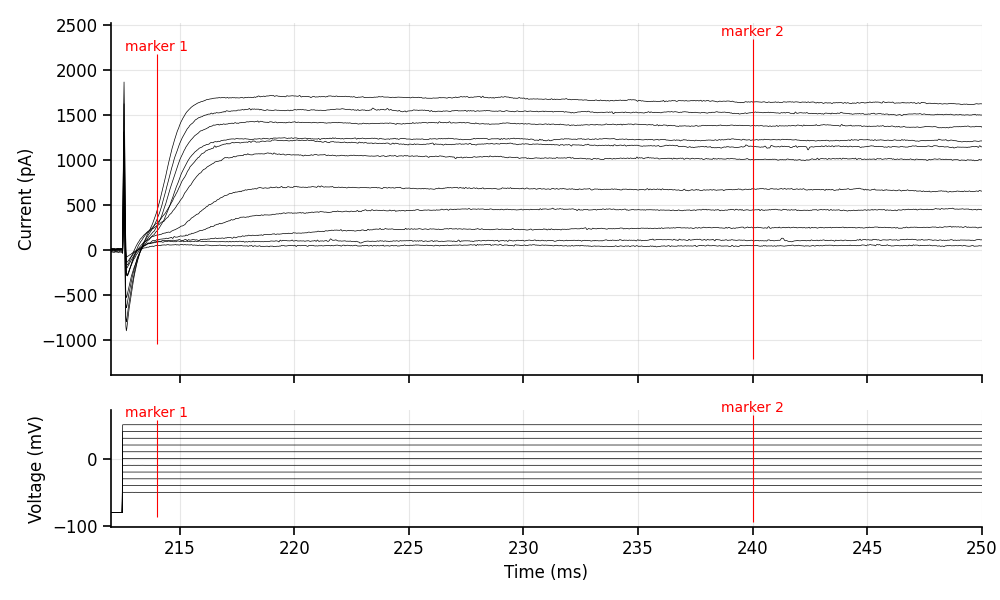

In [16]:
# The start/end time just helps to zoom in on the traces.
start_time = 212
end_time = 250

# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = 214
marker_2 = 240

# ----------------------------------------------------------------------------------------------------------------------
%matplotlib widget
ax1,ax2 = traces.plot(plot_voltage=True, time_units=time_units, marker_1=marker_1, marker_2=marker_2, sweep='all')
ax1.set_xlim(start_time,end_time)
ax2.set_xlim(start_time,end_time)
plt.show()

Once you are happy with the markers, we can crop the trace and fit exponetial curves to get the rise tau

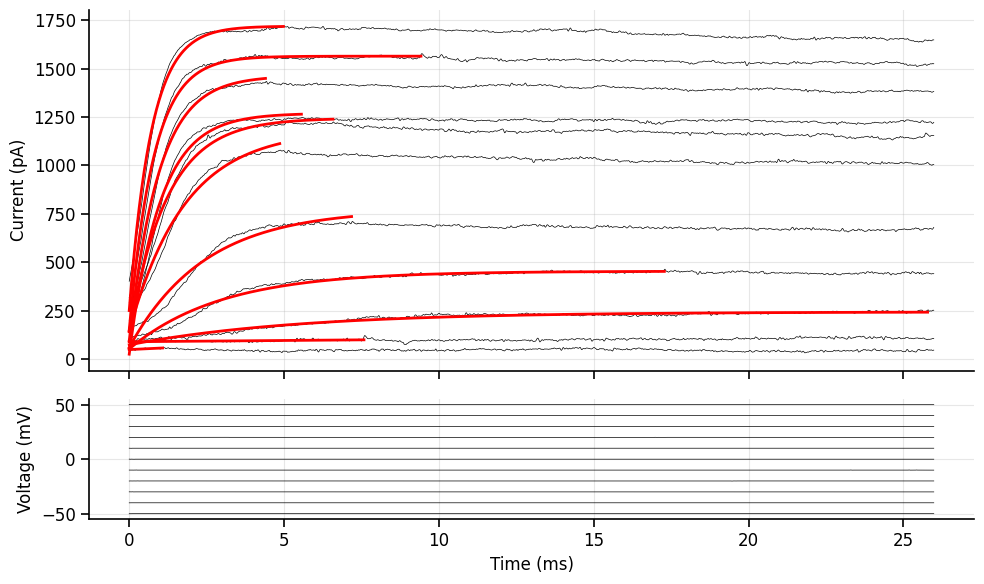

In [24]:
# We need an initial guess for fitting the exponential curve
# (if the fit doesn't work, try to change this value))
tau_guess = 10 # milliseconds

# If the fit still doesn't work, try to change the position of marker 1

# -----------------------------------------------------------------------------------------------------------------
cropped_traces = traces.crop(timepoint=marker_1, timepoint_2=marker_2, time_units=time_units)

%matplotlib inline
ax = cropped_traces.plot(plot_voltage=True, plot_ttl=False, time_units=time_units, sweep='all')

def exponential_curve(time, I_max, tau, I_baseline):
    """
    Rising exponential: I(t) = I_max * (1 - exp(-t/tau)) + I_baseline
    """
    return I_max * (1 - np.exp(-time / tau)) + I_baseline

tau_values = []
voltage_steps = list(cropped_traces.voltage_data[:,0])
time_ms = cropped_traces.time_ms
for i,trace in enumerate(cropped_traces.current_data):
    Imax_guess = trace[0]
    peak_index = np.argmax(np.abs(trace-Imax_guess))
    peak_value = trace[peak_index]
    I_baseline_guess = peak_value
    try:
        fit_params,_ = curve_fit(exponential_curve, time_ms[0:peak_index], trace[0:peak_index], 
                                    p0=[Imax_guess, tau_guess, I_baseline_guess], maxfev=1000000)
        Imax_fit, tau_fit, I_baseline_fit = fit_params
        tau_values.append(tau_fit)

        if Imax_fit < I_baseline_fit: # These are K currents, so we expect and outward (+ve) current
            tau_values.pop()
            voltage_steps.pop(i)
        elif np.abs(tau_fit) > 1000: # Remove outliers (bad fits), we are not expecting a tau > 1 second for these currents
            tau_values.pop()
            voltage_steps.pop(i)

        # Overlay fit
        fit_trace = exponential_curve(time_ms[0:peak_index], *fit_params)
        ax[0].plot(time_ms[0:peak_index], fit_trace[0:peak_index], color='r', alpha=1, linewidth=2)
    except RuntimeError:
        print("Error fitting trace")
        tau_values.append(np.nan)
        continue
plt.show()


Finally, let's plot the the rise timeconstant vs the voltage steps applied.

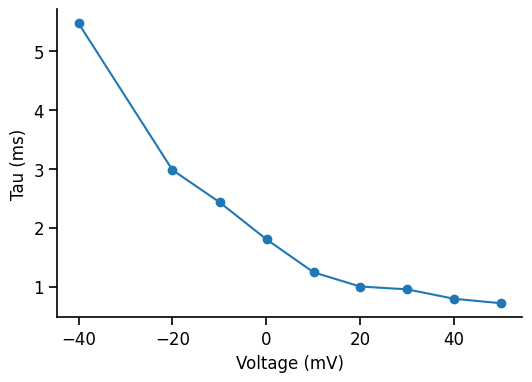

In [25]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(voltage_steps, tau_values, 'o-')
ax.set_ylabel('Tau (ms)')
ax.set_xlabel('Voltage (mV)')
plt.show()

### Optional: export the tau values

If we want to compare different conditions, we can export the tau values, rerun the analysis for the other conditions (e.g. with antagonists), and then plot the values on the same graph

In [19]:
# Save tau values to csv
name = 'K_channel_tau_condition1'
folder = 'outputs/conditions_to_compare/'

import os
os.makedirs(folder, exist_ok=True) # If the folder doesn't exist, create it.
x_data = voltage_steps
y_data = tau_values
data = np.column_stack((x_data, y_data))
np.savetxt(folder + name + '.csv', data, delimiter=',')

from glob import glob
data_files = glob(folder+"/*.csv")
data_files

['outputs/conditions_to_compare/K_channel_tau_condition1.csv']

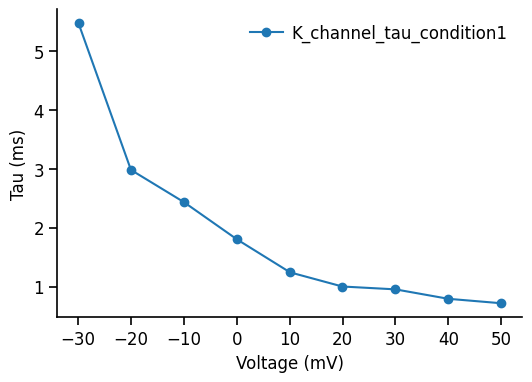

In [20]:
# Load all the files in the folder and plot them on the same graph
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for file in data_files:
    data = np.loadtxt(file, delimiter=',')
    basename = os.path.basename(file)[:-4]
    ax.plot(data[:, 0], data[:, 1],'o-',label=basename)
ax.set_ylabel('Tau (ms)')
ax.set_xlabel('Voltage (mV)')
plt.legend(loc='best', handlelength=2, handletextpad=0.5)
plt.show()